# Regression Analysis of Temporal Processes (Class 10) - FDLs, Panel, Granger

In [337]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from linearmodels.panel import PooledOLS
from linearmodels.panel import PanelOLS
from linearmodels import RandomEffects
from linearmodels import FirstDifferenceOLS

## 1. Lags - distributed lag models

In [7]:
GSS = pd.read_csv('trends-gss.csv')
variables = ['year', 'crimegrows', 'Violent.Crime.rate']
sub = GSS[variables].copy()

KeyError: "['crimegrows' 'Violent.Crime.rate'] not in index"

## Another example

In [33]:
# slide 43
variables = ['attend', 'pray', 'year']
sub = GSS[variables].copy()

In [34]:
# reverse_this function, adapted from R code by Jonah Gabry
# note that in Pandas, you have to explicitly order the categorical variables yourself, either by passing `ordered=True` or specify an order 

def reverse_this(var):
    nvar = pd.to_numeric(var)
    var_max = nvar.max()
    var_min = nvar.min()
    var_sum = var_max + var_min
    var_reversed = var_sum - nvar
    
    if var.dtype.name == 'category' and var.cat.ordered:
        levs = var.cat.categories.tolist()
        c_reversed = pd.Categorical(var_reversed, categories=levs.reverse(), ordered=True)
        return c_reversed
    else:
        return var_reversed

In [35]:
sub['pray'] = reverse_this(sub.pray)

In [145]:
# get means by year
by_year_tmp = sub.groupby('year')[['attend', 'pray']].mean()

In [168]:
# to create rows for additional years, we create a new dataframe that contains each year from 1972 to 2012
# then append the means values for 'attend' and 'pray' from by_year_tmp

by_year = pd.DataFrame({'year': list(np.arange(1972, 2013)), 'attend':0, 'pray':0})
by_year.index = by_year.year

by_year['attend'] = by_year_tmp.attend
by_year['pray'] = by_year_tmp.pray

In [169]:
by_year.reset_index(inplace=True, drop=True)
by_year.loc[len(by_year)+1, 'year'] = 1992

# need to turn year into integer dtype, otherwise will face issue with `to_datetime` function
by_year.year = by_year.year.astype(int)
by_year.sort_values('year', inplace=True)

In [171]:
# slide 44
by_year_ts = by_year.copy()
by_year_ts.index = pd.to_datetime(by_year_ts.year, format='%Y')
by_year_ts = by_year_ts.interpolate(method = 'linear')

by_year_ts = by_year_ts[(by_year_ts.year >= 1983) & (by_year_ts.year<=1992)]

# remove the second 1992 row
by_year_ts= by_year_ts[:-1]

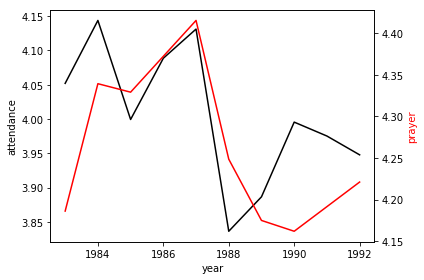

In [174]:
# slide 45

fig, ax1 = plt.subplots()

ax1.set_xlabel('year')
ax1.set_ylabel('attendance', color='black')
ax1.plot(by_year_ts.year, by_year_ts.attend, color='black')

ax2 = ax1.twinx()

ax2.set_ylabel('prayer', color='red')
ax2.plot(by_year_ts.year, by_year_ts.pray, color='red')

fig.tight_layout()

### Correlation of variables

In [175]:
# slide 46
by_year_ts.corr()

,year,attend,pray
year,1.000000,-0.554028,-0.461407
attend,-0.554028,1.000000,0.639347
pray,-0.461407,0.639347,1.000000


## Distributed lag models

In [201]:
# slide 47
dyn0 = smf.ols('pray ~ attend + year', data=by_year_ts).fit()
dyn0.summary()

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pray   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     2.591
Date:                Tue, 14 Aug 2018   Prob (F-statistic):              0.144
Time:                        15:20:38   Log-Likelihood:                 12.966
No. Observations:                  10   AIC:                            -19.93
Df Residuals:                       7   BIC:                            -19.02
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.5787     21.511      0.538      0.607     -39.286      62.443
attend         0.5060      0.315      1.609      0.152      -0.238       1.250
year          -0.0047      0.010     -0.449      0.667      -0.029       0.020
==============================================================================
Omnibus:                        0.776   Durbin-Watson:                   0.800
Prob(Omnibus):                  0.678   Jarque-Bera (JB):                0.674
Skew:                          -0.394   Prob(JB):                        0.714
Kurtosis:                       2.001   Cond. No.                     1.71e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

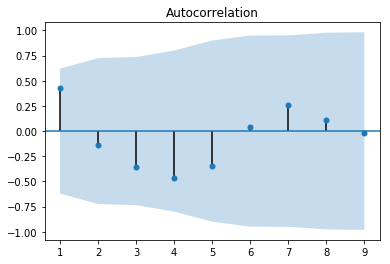

In [179]:
plot_acf(dyn0.resid, zero=False);

In [181]:
# slide 49
lmtest, pval, fval, f_pval = acorr_breusch_godfrey(dyn0, nlags = 1)
print('LM test =', lmtest)
print('p-value =', pval)

LM test = 2.290457744000225
p-value = 0.13017152790031206


In [189]:
# create first lag for attendance
by_year_ts['attend_1'] = by_year_ts.attend.shift(1)

# slide 50
dyn1 = smf.ols('pray ~ attend + attend_1 + year', data=by_year_ts).fit()
dyn1.summary()

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pray   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     8.333
Date:                Tue, 14 Aug 2018   Prob (F-statistic):             0.0217
Time:                        15:11:44   Log-Likelihood:                 17.181
No. Observations:                   9   AIC:                            -26.36
Df Residuals:                       5   BIC:                            -25.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.9245     18.289      0.980      0.372     -29.088      64.937
attend         0.4462      0.196      2.272      0.072      -0.059       0.951
attend_1       0.3739      0.195      1.920      0.113      -0.127       0.874
year          -0.0085      0.009     -0.971      0.376      -0.031       0.014
==============================================================================
Omnibus:                        2.782   Durbin-Watson:                   1.384
Prob(Omnibus):                  0.249   Jarque-Bera (JB):                0.898
Skew:                          -0.015   Prob(JB):                        0.638
Kurtosis:                       1.453   Cond. No.                     2.27e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [190]:
# create second lag for attendance
by_year_ts['attend_2'] = by_year_ts.attend.shift(2)

# slide 52
dyn2 = smf.ols('pray ~ attend + attend_1 + attend_2 + year', data=by_year_ts).fit()
dyn2.summary()

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pray   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     44.08
Date:                Tue, 14 Aug 2018   Prob (F-statistic):            0.00536
Time:                        15:12:33   Log-Likelihood:                 24.294
No. Observations:                   8   AIC:                            -38.59
Df Residuals:                       3   BIC:                            -38.19
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.8230     10.921     -0.442      0.689     -39.578      29.932
attend         0.7147      0.093      7.721      0.005       0.420       1.009
attend_1       0.4134      0.081      5.128      0.014       0.157       0.670
attend_2       0.3908      0.091      4.278      0.023       0.100       0.682
year           0.0015      0.005      0.293      0.788      -0.015       0.018
==============================================================================
Omnibus:                        0.544   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.496
Skew:                           0.190   Prob(JB):                        0.781
Kurtosis:                       1.841   Cond. No.                     3.24e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [228]:
by_year_ts['attend_3'] = by_year_ts.attend.shift(3)

# slide 53
dyn3 = smf.ols('pray ~ attend + attend_1 + attend_2 + attend_3 + year', data=by_year_ts).fit()
dyn3.summary()

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pray   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     351.1
Date:                Tue, 14 Aug 2018   Prob (F-statistic):             0.0405
Time:                        15:45:14   Log-Likelihood:                 32.893
No. Observations:                   7   AIC:                            -53.79
Df Residuals:                       1   BIC:                            -54.11
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -20.2966      6.487     -3.129      0.197    -102.722      62.129
attend         0.7100      0.031     22.554      0.028       0.310       1.110
attend_1       0.5225      0.033     15.905      0.040       0.105       0.940
attend_2       0.4323      0.036     12.152      0.052      -0.020       0.884
attend_3       0.1625      0.036      4.531      0.138      -0.293       0.618
year           0.0087      0.003      2.828      0.216      -0.030       0.048
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.213
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.009
Skew:                           0.150   Prob(JB):                        0.604
Kurtosis:                       1.165   Cond. No.                     5.86e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The fading out of lags

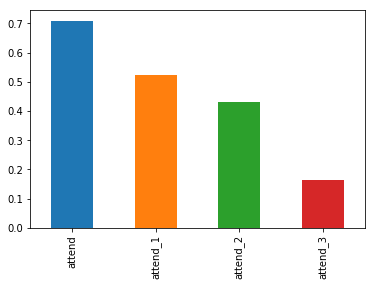

In [196]:
# plot the coeffcients for `attend` based on dyn3 results
dyn3.params[1:5].plot(kind='bar')

### Cumulative lags

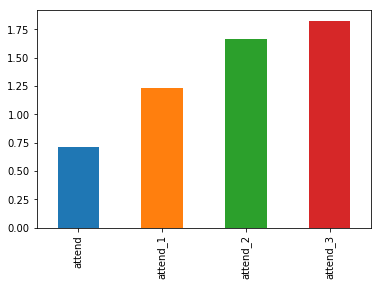

In [199]:
dyn3.params[1:5].cumsum().plot(kind='bar')

### Finite distributed lag process with differences

In [219]:
# create a differenced dataframe
by_year_ts_FD = by_year_ts.diff()

# slide 62
dyn5 = smf.ols('pray ~ attend + attend_1 + attend_2 + attend_3', data=by_year_ts_FD).fit()
dyn5.summary()

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pray   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     100.3
Date:                Tue, 14 Aug 2018   Prob (F-statistic):             0.0747
Time:                        15:30:19   Log-Likelihood:                 25.071
No. Observations:                   6   AIC:                            -40.14
Df Residuals:                       1   BIC:                            -41.18
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0092      0.004      2.084      0.285      -0.047       0.065
attend         0.7305      0.041     17.624      0.036       0.204       1.257
attend_1       0.5208      0.040     12.972      0.049       0.011       1.031
attend_2       0.4411      0.042     10.538      0.060      -0.091       0.973
attend_3       0.1517      0.037      4.075      0.153      -0.321       0.625
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.705
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.292
Skew:                           0.179   Prob(JB):                        0.864
Kurtosis:                       1.981   Cond. No.                         16.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [221]:
from pyramid.arima import auto_arima

In [229]:
auto_arima(dyn3.resid, trace=True)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-61.785, BIC=-61.894, Fit time=0.030 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-72.221, BIC=-72.383, Fit time=0.043 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-63.687, BIC=-63.849, Fit time=0.048 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-70.855, BIC=-71.072, Fit time=0.040 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.167 seconds


/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/pyramid/arima/auto.py:832: ModelFitWarning: Unable to fit ARIMA for order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Users/melindasong/anacon

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend='c')

## Lagged dependent variable

In [230]:
# slide 66

In [320]:
# slide 70
variables = ['year', 'region', 'sex', 'age', 'marital', 'degree']
sub = GSS[variables].copy()

sub['married'] = np.where(pd.isnull(sub.marital), np.nan, 
                          np.where(sub.marital==1, 1, 0))
sub['baplus'] = np.where(pd.isnull(sub.degree), np.nan, 
                         np.where(sub.degree>=3, 1, 0))

sub['marriedlt50'] = np.where(pd.isnull(sub.married) | pd.isnull(sub.age), np.nan, 
                              np.where((sub.married==1) & (sub.age<50), 1, 0))
sub['degreelt50'] = np.where(pd.isnull(sub.baplus) | pd.isnull(sub.age), np.nan,
                              np.where((sub.baplus==1) & (sub.age<50), 1, 0))

by_year_region = sub.groupby(['year', 'region'])[['marriedlt50', 'degreelt50']].mean()
by_year_region.reset_index(drop=False, inplace=True)

In [321]:
import itertools

def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [322]:
interp_dat = expand_grid({'year': [1979, 1981, 1992], 
                          'region': list(np.arange(1, 10))})
interp_dat['marriedlt50'] = np.nan
interp_dat['degreelt50'] = np.nan

by_year_region = pd.concat([by_year_region, interp_dat], sort = False, ignore_index = True)
by_year_region.sort_values(['region', 'year'], inplace=True)
by_year_region.reset_index(drop=True, inplace=True)

In [323]:
# interpolate by region
for i in np.arange(1, 10):
    sel = by_year_region.region==i
    by_year_region[sel] = by_year_region[sel].interpolate(method = 'linear') 

In [324]:
by_year_region['marriedlt50_pct'] = by_year_region['marriedlt50']*100 
by_year_region['degreelt50_pct'] = by_year_region['degreelt50']*100 

by_year_region = by_year_region[by_year_region.year<=1993]

### OLS "Big T, Small N" Panel Regression

In [326]:
# convert to multiindex dataframe
by_year_region = by_year_region.set_index(['region', 'year'], drop=False)

In [327]:
# slide 77

plm_married = PooledOLS.from_formula('marriedlt50 ~ 1 + degreelt50 + year', data=by_year_region).fit(cov_type = 'clustered', 
                                                                                                     cluster_entity = True)
plm_married.summary

Dep. Variable:,marriedlt50,R-squared:,0.2848
Estimator:,PooledOLS,R-squared (Between):,-0.0816
No. Observations:,198,R-squared (Within):,0.3422
Date:,"Tue, Aug 14 2018",R-squared (Overall):,0.2848
Time:,21:13:27,Log-likelihood,290.32
Cov. Estimator:,Clustered,,
,,F-statistic:,38.823
Entities:,9,P-value,0.0000
Avg Obs:,22.000,Distribution:,"F(2,195)"
Min Obs:,22.000,,
Max Obs:,22.000,F-statistic (robust):,114.82


Note: The intercept is higher than what's displayed in the R results because of the wide scale that "year" takes. The fitted values should be the same. 

In [328]:
# slide 79
plm_married = PooledOLS.from_formula('marriedlt50 ~ 1 + degreelt50 + year + C(region)', data=by_year_region).fit(cov_type = 'clustered', 
                                                                                                     cluster_entity = True)
plm_married.summary

Dep. Variable:,marriedlt50,R-squared:,0.4367
Estimator:,PooledOLS,R-squared (Between):,1.0000
No. Observations:,198,R-squared (Within):,0.3483
Date:,"Tue, Aug 14 2018",R-squared (Overall):,0.4367
Time:,21:13:35,Log-likelihood,313.95
Cov. Estimator:,Clustered,,
,,F-statistic:,14.495
Entities:,9,P-value,0.0000
Avg Obs:,22.000,Distribution:,"F(10,187)"
Min Obs:,22.000,,
Max Obs:,22.000,F-statistic (robust):,5.202e+15


In [329]:
# slide 81
plm_married.f_statistic

Model F-statistic (homoskedastic)
H0: All parameters ex. constant not zero
Statistic: 14.4949
P-value: 0.0000
Distributed: F(10,187)
WaldTestStatistic, id: 0x1c2996b6d8

### What about random effects?

In [317]:
by_year_region.head()

year  region  marriedlt50  degreelt50  marriedlt50_pct  \
year region                                                           
1972 1       1972       1     0.566667    0.111111        56.666667   
     2       1972       2     0.462838    0.074830        46.283784   
     3       1972       3     0.438944    0.103333        43.894389   
     4       1972       4     0.418440    0.050360        41.843972   
     5       1972       5     0.403670    0.070755        40.366972   

             degreelt50_pct  
year region                  
1972 1            11.111111  
     2             7.482993  
     3            10.333333  
     4             5.035971  
     5             7.075472

In [330]:
re_married = RandomEffects.from_formula("marriedlt50 ~ 1 + degreelt50 + year", data=by_year_region).fit()
re_married.summary

Dep. Variable:,marriedlt50,R-squared:,0.3378
Estimator:,RandomEffects,R-squared (Between):,-0.1569
No. Observations:,198,R-squared (Within):,0.3481
Date:,"Tue, Aug 14 2018",R-squared (Overall):,0.2796
Time:,21:13:45,Log-likelihood,310.31
Cov. Estimator:,Unadjusted,,
,,F-statistic:,49.728
Entities:,9,P-value,0.0000
Avg Obs:,22.000,Distribution:,"F(2,195)"
Min Obs:,22.000,,
Max Obs:,22.000,F-statistic (robust):,49.728


### Test unit roots

### Individual tests that individual panels are stationary

In [333]:
# slide 91
from statsmodels.tsa.stattools import kpss
from statsmodels.compat import lzip

name = ['kpss_stat', 'p_value', 'lags', 'crit']
test = kpss(by_year_region.loc[by_year_region.region==1, 'marriedlt50'], lags=2)
lzip(name, test)

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


[('kpss_stat', 0.2853723497628789),
 ('p_value', 0.1),
 ('lags', 2),
 ('crit', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]

In [336]:
# slide 92

for i in np.arange(1, 10):
    test = kpss(by_year_region.loc[by_year_region.region==i, 'marriedlt50'], lags=2) 
    print("Test for Region = ", i)
    print(lzip(name, test))

Test for Region =  1
[('kpss_stat', 0.2853723497628789), ('p_value', 0.1), ('lags', 2), ('crit', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]
Test for Region =  2
[('kpss_stat', 0.5786606173693372), ('p_value', 0.024576307511878438), ('lags', 2), ('crit', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]
Test for Region =  3
[('kpss_stat', 0.5658446764598666), ('p_value', 0.026836784581111123), ('lags', 2), ('crit', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]
Test for Region =  4
[('kpss_stat', 0.5445289861654579), ('p_value', 0.031637615728500476), ('lags', 2), ('crit', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]
Test for Region =  5
[('kpss_stat', 0.7051852681253704), ('p_value', 0.013074066534057235), ('lags', 2), ('crit', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]
Test for Region =  6
[('kpss_stat', 0.5809642320455481), ('p_value', 0.024366887995859256), ('lags', 2), ('crit', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, 

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


### 1st differences "Big T, Small N" regression

In [356]:
# slide 96
plm_fd = FirstDifferenceOLS.from_formula("marriedlt50 ~ degreelt50", data=by_year_region).fit()
plm_fd.summary

/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/linearmodels/panel/model.py:1567: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  y = self.dependent.first_difference()
/Users/melindasong/anaconda/envs/py36/lib/python3.6/site-packages/linearmodels/panel/data.py:568: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  diffs = diffs.sw

Dep. Variable:,marriedlt50,R-squared:,0.0945
Estimator:,FirstDifferenceOLS,R-squared (Between):,0.2809
No. Observations:,189,R-squared (Within):,-0.1287
Date:,"Tue, Aug 14 2018",R-squared (Overall):,0.2704
Time:,22:09:05,Log-likelihood,250.24
Cov. Estimator:,Unadjusted,,
,,F-statistic:,19.611
Entities:,9,P-value,0.0000
Avg Obs:,22.000,Distribution:,"F(1,188)"
Min Obs:,22.000,,
Max Obs:,22.000,F-statistic (robust):,19.611


<br>
The test for the serial correlation in panels doesn't seem to be available in Python as of yet, so we will use the R version 

In [358]:
from rpy2.robjects.packages import importr

plm = importr('plm')

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [360]:
%%R -i by_year_region

plm_fd = plm(marriedlt50 ~ degreelt50 , index = c("region", "year"), model="fd", data = by_year_region)
pwfdtest(plm_fd, h0='fd')


	Wooldridge's first-difference test for serial correlation in panels

data:  plm_fd
F = 49.521, df1 = 1, df2 = 178, p-value = 4.088e-11
alternative hypothesis: serial correlation in differenced errors

